In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, Flatten, Dense, Dropout

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, mean_absolute_error

from tensorflow.keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import GridSearchCV

In [3]:
def split_data(df, choose):
  if choose == 1: # 7:2:1
    train_size = int(len(df) * 0.7)
    test_size = int(len(df) * 0.2)
    val_size = len(df) - train_size - test_size

    train_data = df[:train_size]
    test_data = df[train_size:train_size + test_size]
    val_data = df[train_size + test_size:]

  elif choose == 2: # 5:3:2
    train_size = int(len(df) * 0.5)
    test_size = int(len(df) * 0.3)
    val_size = len(df) - train_size - test_size

    train_data = df[:train_size]
    test_data = df[train_size:train_size + test_size]
    val_data = df[train_size + test_size:]

  elif choose == 3: # 6:2:2
    train_size = int(len(df) * 0.6)
    test_size = int(len(df) * 0.2)
    val_size = len(df) - train_size - test_size

    train_data = df[:train_size]
    test_data = df[train_size:train_size + test_size]
    val_data = df[train_size + test_size:]


  print("Train: ", train_size)
  print("Test: ", test_size)
  print("Val: ", val_size)

  return train_data, test_data, val_data


In [4]:
df = pd.read_csv('/content/drive/MyDrive/IS403.N22/Project/dataset/TSLA_Stock.csv',usecols=['Date', 'Price'], parse_dates=['Date'], index_col='Date')
df.head()

,Price
Date,
2017-12-01,20.44
2017-12-04,20.35
2017-12-05,20.25
2017-12-06,20.88
2017-12-07,20.75


In [5]:

scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df.values)

train_data, test_data, val_data = split_data(scaled_data , 1)

Train:  974
Test:  278
Val:  140


In [6]:
n_steps = 10
n_features = 1

def create_sequences(data, n_steps):
    X, y = [], []
    for i in range(len(data) - n_steps):
        X.append(data[i:i + n_steps])
        y.append(data[i + n_steps])
    return np.array(X), np.array(y)

# Tạo input sequences cho training, validation, và testing
X_train, y_train = create_sequences(train_data, n_steps)
X_val, y_val = create_sequences(val_data, n_steps)
X_test, y_test = create_sequences(test_data, n_steps)

In [7]:
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], n_features))
X_val = X_val.reshape((X_val.shape[0], X_val.shape[1], n_features))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], n_features))

#### TCN

In [8]:
def tcn():
  model = Sequential()
  model.add(Conv1D(32, kernel_size=3, activation='relu', padding='causal', input_shape=(n_steps, n_features)))
  model.add(Conv1D(filters=64, kernel_size=3, padding='causal', activation='relu'))
  model.add(Conv1D(filters=64, kernel_size=3, padding='causal', activation='relu', dilation_rate=2))
  model.add(Conv1D(filters=64, kernel_size=3, padding='causal', activation='relu', dilation_rate=4))
  model.add(Conv1D(filters=64, kernel_size=3, padding='causal', activation='relu', dilation_rate=8))
  model.add(Flatten())
  model.add(Dense(1))

  return model

In [9]:
model = tcn()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 10, 32)            128       
                                                                 
 conv1d_1 (Conv1D)           (None, 10, 64)            6208      
                                                                 
 conv1d_2 (Conv1D)           (None, 10, 64)            12352     
                                                                 
 conv1d_3 (Conv1D)           (None, 10, 64)            12352     
                                                                 
 conv1d_4 (Conv1D)           (None, 10, 64)            12352     
                                                                 
 flatten (Flatten)           (None, 640)               0         
                                                                 
 dense (Dense)               (None, 1)                 6

In [10]:
model.compile(loss='mean_squared_error', optimizer=tf.optimizers.Adam(learning_rate=0.001))#, metrics=[MeanAbsolutePercentageError()])
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=100, batch_size=32)

Epoch 1/100
31/31 [==============================] - 2s 25ms/step - loss: 0.0288 - val_loss: 0.0106
Epoch 2/100
31/31 [==============================] - 1s 16ms/step - loss: 0.0012 - val_loss: 0.0062
Epoch 3/100
31/31 [==============================] - 1s 18ms/step - loss: 8.1658e-04 - val_loss: 0.0139
Epoch 4/100
31/31 [==============================] - 1s 20ms/step - loss: 9.8493e-04 - val_loss: 0.0055
Epoch 5/100
31/31 [==============================] - 1s 18ms/step - loss: 6.8005e-04 - val_loss: 0.0060
Epoch 6/100
31/31 [==============================] - 1s 19ms/step - loss: 6.5006e-04 - val_loss: 0.0046
Epoch 7/100
31/31 [==============================] - 1s 19ms/step - loss: 7.3975e-04 - val_loss: 0.0067
Epoch 8/100
31/31 [==============================] - 1s 19ms/step - loss: 6.6198e-04 - val_loss: 0.0047
Epoch 9/100
31/31 [==============================] - 1s 19ms/step - loss: 5.3167e-04 - val_loss: 0.0079
Epoch 10/100
31/31 [==============================] - 1s 19ms/step - los

##### GridSearch TCN

In [11]:
def build_tcn_model(activation):
    model = Sequential()
    model.add(Conv1D(32, kernel_size=3, activation=activation, padding='causal', input_shape=(n_steps, n_features)))
    model.add(Conv1D(filters=64, kernel_size=3, padding='causal', activation=activation))
    model.add(Conv1D(filters=64, kernel_size=3, padding='causal', activation=activation, dilation_rate=2))
    model.add(Conv1D(filters=64, kernel_size=3, padding='causal', activation=activation, dilation_rate=4))
    model.add(Conv1D(filters=64, kernel_size=3, padding='causal', activation=activation, dilation_rate=8))
    model.add(Flatten())
    model.add(Dense(1))

    model.compile(loss='mean_squared_error', optimizer=tf.optimizers.Adam(learning_rate=0.001))

    return model

In [12]:
tcn_model = KerasRegressor(build_fn=build_tcn_model, verbose=0)
param_grid = {'activation': ['relu', 'tanh', 'sigmoid','LeakyReLU']}

grid_tcn = GridSearchCV(estimator=tcn_model, param_grid=param_grid, cv=3, error_score='raise')
grid_tcn_result = grid_tcn.fit(X_train, y_train)

best_activation = grid_tcn_result.best_params_['activation']
print(f'Best activation: {best_activation}')

<ipython-input-12-678638f71ac0>:1: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  tcn_model = KerasRegressor(build_fn=build_tcn_model, verbose=0)


Best activation: tanh


In [13]:
model_best = build_tcn_model(best_activation)
history = model_best.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=100, batch_size=32)

Epoch 1/100
31/31 [==============================] - 2s 19ms/step - loss: 0.0050 - val_loss: 0.0075
Epoch 2/100
31/31 [==============================] - 0s 13ms/step - loss: 8.4544e-04 - val_loss: 0.0060
Epoch 3/100
31/31 [==============================] - 0s 12ms/step - loss: 8.5888e-04 - val_loss: 0.0062
Epoch 4/100
31/31 [==============================] - 0s 14ms/step - loss: 6.9522e-04 - val_loss: 0.0049
Epoch 5/100
31/31 [==============================] - 0s 13ms/step - loss: 6.3455e-04 - val_loss: 0.0078
Epoch 6/100
31/31 [==============================] - 1s 17ms/step - loss: 7.8959e-04 - val_loss: 0.0060
Epoch 7/100
31/31 [==============================] - 1s 16ms/step - loss: 4.7670e-04 - val_loss: 0.0078
Epoch 8/100
31/31 [==============================] - 0s 13ms/step - loss: 4.7540e-04 - val_loss: 0.0034
Epoch 9/100
31/31 [==============================] - 1s 20ms/step - loss: 5.6620e-04 - val_loss: 0.0037
Epoch 10/100
31/31 [==============================] - 0s 14ms/step -

##### Evaluation model

In [14]:
def evaluation_model(model):
  # evaluate trên tập test
  loss_test = model.evaluate(X_test, y_test, verbose=0)
  print("loss_test: ", loss_test)

  # evaluate trên tập val
  loss_val = model.evaluate(X_val, y_val, verbose=0)
  print("loss_val: ", loss_val)

In [15]:
evaluation_model(model)

loss_test:  0.0013025352964177728
loss_val:  0.0003136309387627989


In [16]:
evaluation_model(model_best)

loss_test:  0.0012670033611357212
loss_val:  0.0003637885383795947


In [17]:
y_train = scaler.inverse_transform(y_train)
y_test = scaler.inverse_transform(y_test)
y_val = scaler.inverse_transform(y_val)

In [18]:
def mae_rmse_mape(true, predict):
  mae = mean_absolute_error(true, predict)
  rmse = np.sqrt(mean_squared_error(true, predict))
  mape = mean_absolute_percentage_error(true, predict)

  return mae, rmse, mape

In [19]:
def predict_future(model, number_days):
  last_sequence = X_val[-1:]
  predicted_values = []
  for _ in range(number_days):
    next_value = model.predict(last_sequence)
    predicted_values.append(next_value[0, 0])
    last_sequence = np.append(last_sequence[:, 1:, :], [next_value], axis=1)
  predicted_values = scaler.inverse_transform(np.array(predicted_values).reshape(-1, 1))
  predicted_values = np.array(predicted_values).reshape(-1, 1)
  return predicted_values

In [20]:
def metrics(model):
  y_pred_test = model.predict(X_test)
  y_pred_val = model.predict(X_val)

  y_pred_test = scaler.inverse_transform(y_pred_test)
  y_pred_val = scaler.inverse_transform(y_pred_val)


  mae_test, rmse_test, mape_test = mae_rmse_mape(y_test, y_pred_test)
  mae_val, rmse_val, mape_val = mae_rmse_mape(y_val, y_pred_val)
# mae_test, rmse_test, mape_test = mae_rmse_mape(y_test, model.predict(X_test))
# mae_val, rmse_val, mape_val = mae_rmse_mape(y_val, model.predict(X_val))

  print('MAE of Test: ', mae_test)
  print('RMSE of Test: ', rmse_test)
  print('MAPE of Test: ', mape_test)
  print('------------------------')
  print('MAE of Validation: ', mae_val)
  print('RMSE of Validation: ', rmse_val)
  print('MAPE of Validation: ', mape_val)

In [21]:
metrics(model)

5/5 [==============================] - 0s 3ms/step
MAE of Test:  11.154286542294631
RMSE of Test:  14.365528071626684
MAPE of Test:  0.037829507018874546
------------------------
MAE of Validation:  5.410738112229567
RMSE of Validation:  7.049142686219218
MAPE of Validation:  0.031831954000843155


In [22]:
metrics(model_best)

5/5 [==============================] - 0s 4ms/step
MAE of Test:  10.795027194805998
RMSE of Test:  14.168236010365632
MAPE of Test:  0.03659881657218739
------------------------
MAE of Validation:  5.938273836576022
RMSE of Validation:  7.5919138829189095
MAPE of Validation:  0.035713811604032884


##### Visualization TCN

In [23]:
number_days = 30

train_actual = scaler.inverse_transform(train_data.reshape(-1, 1))
val_actual = scaler.inverse_transform(val_data.reshape(-1, 1))
test_actual = scaler.inverse_transform(test_data.reshape(-1, 1))

# val_predictions = scaler.inverse_transform(model.predict(X_val))
# test_predictions = scaler.inverse_transform(model.predict(X_test))



# train_actual = train_data.reshape(-1, 1)
# val_actual = val_data.reshape(-1, 1)
# test_actual = test_data.reshape(-1, 1)

# val_predictions = model.predict(X_val)
# test_predictions = model.predict(X_test)

In [24]:
train_actual.shape, y_train.shape

((974, 1), (964, 1))

In [25]:
def visualization(model):
  y_pred_test = model.predict(X_test)
  y_pred_val = model.predict(X_val)

  y_pred_test = scaler.inverse_transform(y_pred_test)
  y_pred_val = scaler.inverse_transform(y_pred_val)

  plt.figure(figsize=(12,6))

  plt.plot(range(len(y_train)), y_train, label='Train')

  plt.plot(range(len(y_train), len(y_train) + len(y_test)), y_test, label='Test')
  plt.plot(range(len(y_train), len(y_train) + len(y_test)), y_pred_test, label='Test Prediction')

  plt.plot(range(len(y_train) + len(y_test), len(y_train) + len(y_test) + len(y_val)), y_val, label='Validation')
  plt.plot(range(len(y_train) + len(y_test), len(y_train) + len(y_test) + len(y_val)), y_pred_val, label='Validation Prediction')

  # predicted_values = predict_future(model, number_days)
  # plt.plot(range(len(y_train) + len(y_test) + len(y_val), len(y_train) + len(y_test) + len(y_val) + number_days), predicted_values, label='30days_Next')

  plt.legend()
  plt.show()

5/5 [==============================] - 0s 4ms/step


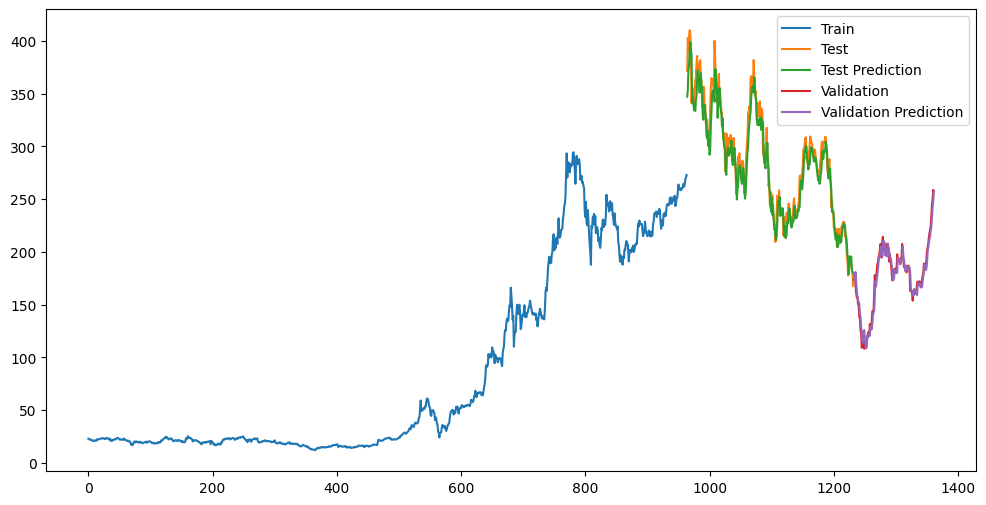

In [26]:
visualization(model)

5/5 [==============================] - 0s 4ms/step


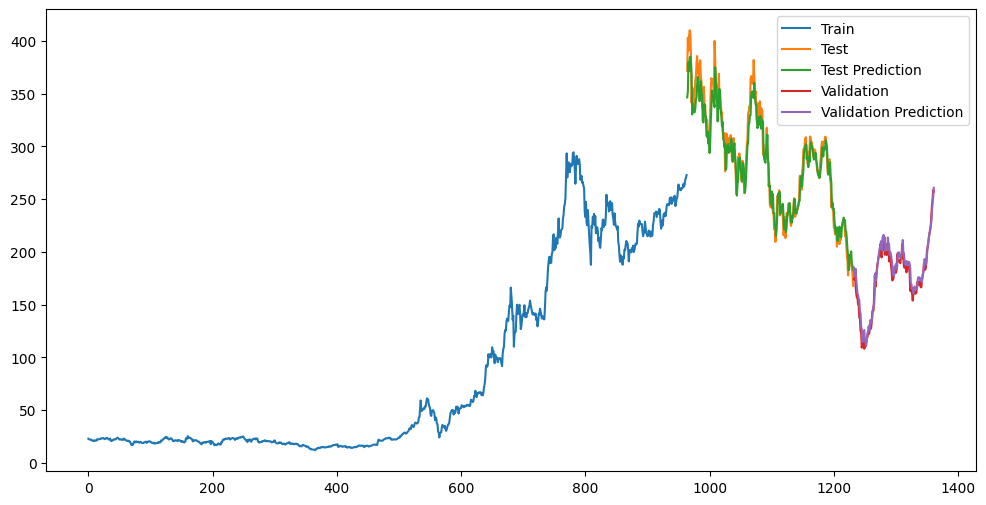

In [27]:
visualization(model_best)

In [28]:

# dates = df.index

# # Plot the training data
# plt.figure(figsize=(12, 8))
# plt.plot(dates[:len(train_actual)], train_actual, label='Train')

# # Plot the validation data
# test_offset = len(train_actual)
# plt.plot(dates[test_offset:test_offset + len(test_actual)], test_actual, label='Test')
# plt.plot(dates[test_offset:test_offset + len(test_predictions)], test_predictions, label='Test Predictions')

# # Plot the testing data
# val_offset = test_offset + len(test_actual)
# plt.plot(dates[val_offset:val_offset + len(val_actual)], val_actual, label='Validation')
# plt.plot(dates[val_offset:val_offset + len(val_predictions)], val_predictions, label='Validation Predictions')

# predicted_values = predict_future(model, number_days)
# next30days_offset = pd.date_range(start=dates[-1], periods=31, closed='right')
# plt.plot(next30days_offset, predicted_values, label='30 next days')

# # Rotate x-axis labels for better visibility
# plt.xticks(rotation=45)
# plt.legend()
# plt.show()
